In [ ]:
# Author: Pierre Jeanne
# Date Created:  10 June 2021

# JOB-A-THON - May 2021- Credit Card Lead Prediction
## Credit Card Lead Prediction

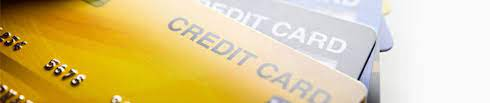

### Problem Statement :

We have to predict which customer will be interested or not in buying a credit card.

In [ ]:
import numpy as np
import pandas as pd
import pandas_profiling as pp

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# slip the data
from sklearn.model_selection import train_test_split
# scale the data
from sklearn.preprocessing import RobustScaler
# cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# classification model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
# hyperparameter tunning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# model evaluation
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">1: Exploratory Data Analysis
</p>
</div>

**1.1: Load the training and testing data set**

In [ ]:
df_train=pd.read_csv(r"../input/jobathon-may-2021-credit-card-lead-prediction/train.csv")
df_train.head()

In [ ]:
df_test=pd.read_csv(r"../input/jobathon-may-2021-credit-card-lead-prediction/test.csv")
df_test.head()

**1.2: General information**

In [ ]:
print('shape of the training set: ', df_train.shape)
print('shape of the testing set: ', df_test.shape)

In [ ]:
df_train.info()

In [ ]:
df_test.info()

In [ ]:
df_train.isnull().sum()

In [ ]:
df_test.isnull().sum()

**1.3: basic stats numerical variables**

-- the training set --

In [ ]:
df_train.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

-- the testing set --

In [ ]:
df_test.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

In [ ]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4,wspace=0.3)

ax1 = fig.add_subplot(2,2,1)
sns.histplot(x=df_train['Age'], kde=True, ax=ax1,label='df_train')
sns.histplot(x=df_test['Age'], kde=True, ax=ax1,color = 'red',label='df_test')
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
sns.histplot(x=df_train['Vintage'], kde=True, ax=ax2,label='df_train')
sns.histplot(x=df_test['Vintage'], kde=True, ax=ax2,color = 'red',label='df_test')
ax2.legend()

ax3 = fig.add_subplot(2,2,3)
sns.histplot(x=df_train['Avg_Account_Balance'], kde=True, ax=ax3,label='df_train')
sns.histplot(x=df_test['Avg_Account_Balance'], kde=True, ax=ax3,color = 'red',label='df_test')
ax3.legend()

ax4 = fig.add_subplot(2,2,4)
sns.histplot(x=np.log(df_train['Avg_Account_Balance']), kde=True, ax=ax4,label='df_train')
sns.histplot(x=np.log(df_test['Avg_Account_Balance']), kde=True, ax=ax4,color = 'red',label='df_test')
ax4.set_title('log Avg_Account_Balance')
ax4.legend()

plt.show()

The distribution are the same, but some age and vintage are present in the training set but not in the testing set, and inversely.

In [ ]:
total = len(df_train)
def add_percentage(ax,rotation):
    # add percentage
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center',rotation=rotation)

In [ ]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4,wspace=0.3)

# figure title
fig.suptitle("Distribution categorical vaiables:", fontsize=18)

# subplot
ax1 = fig.add_subplot(3,2,1)
ax1 = sns.countplot(df_train['Gender'])
add_percentage(ax1,rotation='horizontal')

ax2 = fig.add_subplot(3,2,2)
ax2 = sns.countplot(df_train['Region_Code'])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right',size=10)
add_percentage(ax2,rotation='vertical')

ax3 = fig.add_subplot(3,2,3)
ax3 = sns.countplot(df_train['Occupation'])
add_percentage(ax3,rotation='horizontal')

ax4 = fig.add_subplot(3,2,4)
ax4 = sns.countplot(df_train['Channel_Code'])
add_percentage(ax4,rotation='horizontal')

ax5 = fig.add_subplot(3,2,5)
ax5 = sns.countplot(df_train['Credit_Product'])
add_percentage(ax5,rotation='horizontal')

ax6 = fig.add_subplot(3,2,6)
ax6 = sns.countplot(df_train['Is_Active'])
add_percentage(ax6,rotation='horizontal')


There are to many `region code` with a very low percentage, so we can collapse many categories into a few. 

In [ ]:
df1 = df_train.groupby(['Region_Code']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count',ascending=False)
df1['%'] = df1['count']*100/(len(df_train))
df1

In [ ]:
df_region_to_group = df1[df1['%']<3]
list_region_to_group = df_region_to_group['Region_Code'].tolist()
list_region_to_group

In [ ]:
for code in list_region_to_group:
    df_train['Region_Code'].replace(code,'other',inplace=True)
    df_test['Region_Code'].replace(code,'other',inplace=True)

**1.4: Target distribution**

In [ ]:
fig = plt.figure(figsize=(5,5))
# fig.subplots_adjust(hspace=0.4,wspace=0.3)

# figure title
fig.suptitle("Distribution target vaiable:", fontsize=18)

# subplot
ax1 = fig.add_subplot(1,1,1)
ax1 = sns.countplot(df_train['Is_Lead'])
add_percentage(ax1,rotation='horizontal')

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">2: Relations variables vs target 
</p>
</div>

In [ ]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4,wspace=0.3)

# figure title
fig.suptitle("relations between numerical vaiables:", fontsize=18)

# subplot
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.scatterplot(data=df_train, x="Age", y="Vintage", hue="Is_Lead",s=60)
# subplot
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.scatterplot(data=df_train, x="Age", y="Avg_Account_Balance", hue="Is_Lead",s=60)
# subplot
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.scatterplot(data=df_train, x="Vintage", y="Avg_Account_Balance", hue="Is_Lead",s=60)

In [ ]:
ax1 = sns.catplot(x='Gender',y="Age",data=df_train,kind='box',hue='Is_Lead')
ax1.fig.suptitle('Is_Lead vs Gender and Age')

ax2 = sns.catplot(x='Region_Code',y="Age",data=df_train,kind='box',hue='Is_Lead')
ax2.fig.suptitle('Is_Lead vs Region_Code and Age')

ax3 = sns.catplot(x='Occupation',y="Age",data=df_train,kind='box',hue='Is_Lead')
ax3.fig.suptitle('Is_Lead vs Occupation and Age')

ax4 = sns.catplot(x='Channel_Code',y="Age",data=df_train,kind='box',hue='Is_Lead')
ax4.fig.suptitle('Is_Lead vs Channel_Code and Age')

ax5 = sns.catplot(x='Credit_Product',y="Age",data=df_train,kind='box',hue='Is_Lead')
ax5.fig.suptitle('Is_Lead vs Credit_Product and Age')

ax5 = sns.catplot(x='Is_Active',y="Age",data=df_train,kind='box',hue='Is_Lead')
ax5.fig.suptitle('Is_Lead vs Is_Active and Age')

# Show plot
plt.show()

In [ ]:
ax1 = sns.catplot(x='Gender',y="Vintage",data=df_train,hue='Is_Lead',kind="box")
ax1.fig.suptitle('Is_Lead vs Gender and Age')

ax2 = sns.catplot(x='Region_Code',y="Vintage",data=df_train,hue='Is_Lead',kind="box")
ax2.fig.suptitle('Is_Lead vs Region_Code and Age')

ax3 = sns.catplot(x='Occupation',y="Vintage",data=df_train,hue='Is_Lead',kind="box")
ax3.fig.suptitle('Is_Lead vs Occupation and Age')

ax4 = sns.catplot(x='Channel_Code',y="Vintage",data=df_train,hue='Is_Lead',kind="box")
ax4.fig.suptitle('Is_Lead vs Channel_Code and Age')

ax5 = sns.catplot(x='Credit_Product',y="Vintage",data=df_train,hue='Is_Lead',kind="box")
ax5.fig.suptitle('Is_Lead vs Credit_Product and Age')

ax5 = sns.catplot(x='Is_Active',y="Vintage",data=df_train,hue='Is_Lead',kind="box")
ax5.fig.suptitle('Is_Lead vs Is_Active and Age')

# Show plot
plt.show()

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">3: Preprocessing 
</p>
</div>

**3.1: feature engineering**

In [ ]:
# calculate age when client sign in
df_train['age_initial'] = df_train['Age'] - df_train['Vintage']/12 
df_test['age_initial'] = df_test['Age'] - df_test['Vintage']/12 

# calculate log Avg_Account_Balance 
df_train['log_Avg_Account_Balance'] = np.log(df_train['Avg_Account_Balance'])
df_test['log_Avg_Account_Balance'] = np.log(df_test['Avg_Account_Balance'])

# calculate yearly - log Avg_Account_Balance 
df_train['yearly_log_Avg_Account_Balance'] = np.log(df_train['Avg_Account_Balance']/(df_train['Vintage']/12))
df_test['yearly_log_Avg_Account_Balance'] = np.log(df_test['Avg_Account_Balance']/(df_test['Vintage']/12))


In [ ]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4,wspace=0.3)

ax1 = fig.add_subplot(2,2,1)
sns.histplot(x=df_train['age_initial'], kde=True, ax=ax1,label='df_train')
sns.histplot(x=df_test['age_initial'], kde=True, ax=ax1,color = 'red',label='df_test')
ax1.legend()

ax2 = fig.add_subplot(2,2,2)
sns.histplot(x=df_train['log_Avg_Account_Balance'], kde=True, ax=ax2,label='df_train')
sns.histplot(x=df_test['log_Avg_Account_Balance'], kde=True, ax=ax2,color = 'red',label='df_test')
ax2.legend()

ax3 = fig.add_subplot(2,2,3)
sns.histplot(x=df_train['yearly_log_Avg_Account_Balance'], kde=True, ax=ax3,label='df_train')
sns.histplot(x=df_test['yearly_log_Avg_Account_Balance'], kde=True, ax=ax3,color = 'red',label='df_test')
ax3.legend()

plt.show()

**3.2: unwanted columns and missing values**

In [ ]:
df_train = df_train.drop('ID',axis=1)
df_test = df_test.drop('ID',axis=1)

In [ ]:
# replace nan value by 'missing'
df_train['Credit_Product'].replace(np.nan,'Missing',inplace=True)
df_test['Credit_Product'].replace(np.nan,'Missing',inplace=True)


**3.3: define predictor and target variable**

In [ ]:
# split the data into predictor and target
target = df_train['Is_Lead']
X = df_train.drop(['Is_Lead'],axis=1)
# convert categorical data into numerical
X = pd.get_dummies(X,drop_first = True)

**3.4: Splitting Dataset into train and test set**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,target,test_size=0.2,random_state=0)

**3.5: Scale the data**

In [ ]:
# scale the data


scaler = RobustScaler()
numeric_col = ['Age', 'Vintage', 'Avg_Account_Balance', 'age_initial','log_Avg_Account_Balance', 'yearly_log_Avg_Account_Balance']
# fit and transform "x_train"
X_train.loc[:,numeric_col] = scaler.fit_transform(X_train[numeric_col])
# transform "x_test"
X_test.loc[:,numeric_col] = scaler.transform(X_test[numeric_col])

In [ ]:
corr = X_train.corr(method='pearson')

fig, axes = plt.subplots(1,figsize=(18,18))
ax0 = plt.subplot(1,1,1)
sns.heatmap(corr,annot=True,linewidths=.5, annot_kws={"size": 10},vmin=-1.0, vmax=1.0,square=True,cbar=True)
# bottom, top = ax0.get_ylim()
# ax0.set_ylim(bottom + 0.5, top - 0.5)
# ax0.set_title('correlations between numerical variables',size=18,y=1.05)
# ax0.set_yticklabels(ax0.get_yticklabels(), rotation=0,size=14) 
# ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90,size=14) 
plt.show()

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">4: Classification 
</p>
</div>

In [ ]:
list_scores = []
def plot_result_cv(model,pred,name):
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues,normalize=True);  
    accuracy = accuracy_score(y_test,pred)
    recall = recall_score(y_test,pred)
    precision = precision_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1: ', f1)
    list_scores.append({'Model Name': name, 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1':f1})
    plt.show()
    

In [ ]:
cv_strat = StratifiedKFold(n_splits=4,random_state=42,shuffle=True)

**4.1:  Classification with LogisticRegression**

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(class_weight= 'balanced')

# Setup the parameters and distributions to sample from: param_dist
parameters = {'penalty': ['l1','l2', 'elasticnet','none']}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf_lr, param_grid = parameters, 
                          cv = cv_strat, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
model_lr = LogisticRegression(class_weight= 'balanced',penalty='none')
model_lr.fit(X_train, y_train)
# make prediction
pred = model_lr.predict(X_test)
plot_result_cv(model_lr,pred,'lr')

**4.2:  Classification with LinearSVC**

In [ ]:
from sklearn.svm import LinearSVC

model_svc = LinearSVC()
model_svc.fit(X_train, y_train)
# make prediction
pred = model_svc.predict(X_test)
# plot_confusion_matrix(model_svc, X_test, y_test, cmap=plt.cm.Blues)
# plot result cv
plot_result_cv(model_svc,pred,'svc_l2')

**4.3: Classification with k-Nearest Neighbors** 

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# param_grid = {'n_neighbors':np.arange(13,18,1)}
# knn = KNeighborsClassifier()

# knn_cv= GridSearchCV(knn,param_grid,cv=cv_strat)
# knn_cv.fit(X_train,y_train)
# knn_cv.best_params_

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=15)
model_knn.fit(X_train, y_train)
# make prediction
pred = model_knn.predict(X_test)
plot_result_cv(model_knn,pred,'knn')

**4.4: Classification with Support Vector Machines**